In [1]:
import sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import copy
import time

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
%matplotlib notebook

### Load data

In [ ]:
dfolder = r'C:\Users\lesliec\data\EEG_exp\mouse521886\audio_vis1_2020-07-15_13-28-29\recording1'
# dfolder = r'E:\eeg_pilot\mouse496220\audio_vis4_2020-06-18_13-49-17\recording1'
# load experiment metadata and eeg data
exp = EEGexp(dfolder, preprocess=False)

In [6]:
print(exp.sync_file)

C:\Users\lesliec\OneDrive - Allen Institute\data\EEG_Cannula\mouse526378\rec1_2020-11-24_13-08-21\experiment1\recording1\mouse526378201124130743.sync


In [7]:
sync_data = exp._load_sync_dataset()

In [8]:
print(sync_data.line_labels)

['barcodes', 'opto_copy', 'frames', 'behavior_sweep', 'photodiode', 'sweep', '', 'behavior_vsync', 'eyetracking', 'behavior', 'rotA', 'rotB', 'estim_sync', 'estim_sweep', '', '', '', 'opto_sweep', 'opto_trial', '', '', '', '', '', '', '', '', '', '', '', '', '']


### Load the stim table and log file

In [9]:
# # stimulus table
# stim_file = glob(exp.data_folder + '/*_table.csv', recursive=True)[0]
# print(stim_file)

# log file
# log_file = glob(exp.data_folder + '/*_stimulus_log.csv', recursive=True)[0]
log_file = exp.stim_instruction_files['sensory'][0]
print(log_file)

C:\Users\lesliec\data\EEG_exp\mouse521886\audio_vis1_2020-07-15_13-28-29\recording1\2020-07-15_13-57-27_stimulus_log.csv


In [10]:
stim_log = pd.read_csv(log_file)
stim_log.head()

,time,frame,display_stim,stim_type,stim_parameter
0,0.314396,0,False,gray_screen,none
1,0.327525,1,False,gray_screen,none
2,0.344182,2,False,gray_screen,none
3,0.360863,3,False,gray_screen,none
4,0.377541,4,False,gray_screen,none


In [12]:
# print('Number of stimuli in stim_table: %d' % (len(stim_table)-1)) # -1 because of "end" line
print('Number of entries in stim_log: %d' % len(stim_log))

Number of entries in stim_log: 98756


### Check rising and falling edges

In [13]:
srising = sync_data.get_edges(keys=('behavior_sweep',), kind='rising', units='seconds')
sfalling = sync_data.get_edges(keys=('behavior_sweep',), kind='falling', units='seconds')

vrising = sync_data.get_edges(keys=('behavior_vsync',), kind='rising', units='seconds')
vfalling = sync_data.get_edges(keys=('behavior_vsync',), kind='falling', units='seconds')

In [14]:
print('behavior_sweep info')
print('number of rising/falling: %d/%d' % (len(srising), len(sfalling)))
print('first rising: %f' % srising[0])
print('first falling: %f' % sfalling[0])

behavior_sweep info
number of rising/falling: 2/2
first rising: 35.057570
first falling: 885.823530


In [15]:
print('behavior_vsync info')
print('number of rising/falling: %d/%d' % (len(vrising), len(vfalling)))
print('first rising: %f' % vrising[0])
print('first falling: %f' % vfalling[0])

behavior_vsync info
number of rising/falling: 98756/98756
first rising: 35.059340
first falling: 35.370920


### Combine log with vsync rising and falling times

In [16]:
sync_log = stim_log.drop(labels='time', axis='columns')
sync_log['vsync_rising'] = vrising
sync_log['vsync_falling'] = vfalling
sync_log.head()

,frame,display_stim,stim_type,stim_parameter,vsync_rising,vsync_falling
0,0,False,gray_screen,none,35.05934,35.37092
1,1,False,gray_screen,none,35.37158,35.38405
2,2,False,gray_screen,none,35.38440,35.40071
3,3,False,gray_screen,none,35.40104,35.41739
4,4,False,gray_screen,none,35.41772,35.43407


In [17]:
start = time.time()
list_stim_type = []
list_stim_param = []
list_onset_times = []
list_offset_times = []
for i in range(1, len(sync_log)):
    if sync_log.stim_type.iloc[i-1] == 'gray_screen' and sync_log.stim_type.iloc[i] == 'fullscreen':
        list_onset_times.append(sync_log.vsync_falling.iloc[i]) # vsync_falling is visual stim onset
        list_stim_type.append(sync_log.stim_type.iloc[i])
        list_stim_param.append(sync_log.stim_parameter.iloc[i]) # to make sure order matches stim table
    elif sync_log.stim_type.iloc[i-1] == 'fullscreen' and sync_log.stim_type.iloc[i] == 'gray_screen':
        list_offset_times.append(sync_log.vsync_falling.iloc[i]) # gray_screen vsync_falling is visual stim offset
    elif sync_log.stim_type.iloc[i-1] == 'gray_screen' and sync_log.stim_type.iloc[i] == 'auditory':
        list_onset_times.append(sync_log.vsync_rising.iloc[i]) # vsync_rising is aditory stim onset
        list_offset_times.append(sync_log.vsync_falling.iloc[i]) # vsync_falling is aditory stim offset
        list_stim_type.append(sync_log.stim_type.iloc[i])
        list_stim_param.append(sync_log.stim_parameter.iloc[i])
end = time.time()
print('Time to loop through stim log: %0.2f seconds' % (end-start))

Time to loop through stim log: 5.82 seconds


#### Now build stim table log with vsync onset/offset times (falling edge for visual stim, rising for auditory) *** These times are not yet corrected for visual/auditory display lag.

In [18]:
vsync_log = pd.DataFrame({
    'stim_type': list_stim_type,
    'stim_parameter': list_stim_param,
    'onset': list_onset_times,
    'offset': list_offset_times
})
vsync_log.head()

,stim_type,stim_parameter,onset,offset
0,fullscreen,white,39.42214,39.68899
1,fullscreen,black,43.99231,44.25918
2,auditory,10000,48.59651,48.85716
3,fullscreen,black,52.88247,53.14933
4,fullscreen,white,56.81883,57.08570


#### Now what about onset/offset lag??

In [19]:
samp_rate = sync_data.analog_meta_data['analog_sample_rate']
print(samp_rate)

10000.0


C:\Users\lesliec\AppData\Local\Continuum\miniconda3\envs\tbd_eeg\lib\site-packages\allensdk\brain_observatory\sync_dataset.py:454: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return eval(self.dfile['analog_meta'].value)


Let's look at the photodiode for visual stim lags.

In [20]:
photodiode = sync_data.get_analog_channel('photodiode')
speaker_input = sync_data.get_analog_channel('speaker_input')
synctime = np.arange(0, len(photodiode))/samp_rate

### Loop through and find delays (for both onset and offset)

In [21]:
## Find delays ##
search_window = 0.1 # s, before and after
search_sample = int(search_window * samp_rate)
# try
z_thresh = 5

onset_delays = np.zeros(len(vsync_log)) # initialize array to hold delays
offset_delays = np.zeros(len(vsync_log)) # initialize array to hold delays
for ind, row in vsync_log.iterrows():
    onset_ind = int(row.onset * samp_rate)
    offset_ind = int(row.offset * samp_rate)

    if row.stim_type == 'fullscreen':
        onset_chunk = photodiode[onset_ind - search_sample:onset_ind + search_sample]
        offset_chunk = photodiode[offset_ind - search_sample:offset_ind + search_sample]
    elif row.stim_type == 'auditory':
        onset_chunk = speaker_input[onset_ind - search_sample:onset_ind + search_sample]
        offset_chunk = speaker_input[offset_ind - search_sample:offset_ind + search_sample]

    # TIME stamps for chunks
    onset_t = synctime[onset_ind - search_sample:onset_ind + search_sample] - row.onset
    offset_t = synctime[offset_ind - search_sample:offset_ind + search_sample] - row.offset

    # ONSET DELAY
    onset_z = np.abs((onset_chunk - np.mean(onset_chunk[0:search_sample]))/np.std(onset_chunk[0:search_sample]))
    onset_z_thresh = z_thresh # (np.max(onset_z) - np.min(onset_z))*0.5
    onset_delays[ind] = onset_t[np.argwhere(onset_z > onset_z_thresh)[0]]

    # OFFSET DELAY
    if row.stim_type == 'fullscreen':
        offset_z = np.abs((offset_chunk - np.mean(offset_chunk[0:search_sample]))/np.std(offset_chunk[0:search_sample]))
        offset_z_thresh = z_thresh # (np.max(offset_z) - np.min(offset_z))*0.5
        offset_delays[ind] = offset_t[np.argwhere(offset_z > offset_z_thresh)[0]]
    elif row.stim_type == 'auditory':
        offset_delays[ind] = 0. # do not need to adjust the offset time of auditory stimuli

## Add onset_delays and offset_delays to vsync_log ##
vsync_log['onset_delay'] = onset_delays
vsync_log['offset_delay'] = offset_delays
vsync_log['duration'] = vsync_log['offset']+vsync_log['offset_delay']-vsync_log['onset']-vsync_log['onset_delay']
vsync_log

,stim_type,stim_parameter,onset,offset,onset_delay,offset_delay,duration
0,fullscreen,white,39.42214,39.68899,0.02866,0.02871,0.26690
1,fullscreen,black,43.99231,44.25918,0.02889,0.02992,0.26790
2,auditory,10000,48.59651,48.85716,0.01199,0.00000,0.24866
3,fullscreen,black,52.88247,53.14933,0.02893,0.02987,0.26780
4,fullscreen,white,56.81883,57.08570,0.02877,0.02870,0.26680
...,...,...,...,...,...,...,...
395,auditory,10000,2074.37057,2074.63406,0.01493,0.00000,0.24856
396,auditory,10000,2078.20693,2078.47413,0.01877,0.00000,0.24843
397,fullscreen,white,2082.87583,2083.14271,0.02877,0.02879,0.26690
398,auditory,10000,2086.68006,2086.94445,0.01564,0.00000,0.24875


In [22]:
vsync_log.groupby(['stim_type']).mean()

,onset,offset,onset_delay,offset_delay,duration
stim_type,,,,,
auditory,1068.442211,1068.707083,0.014588,0.000000,0.250284
fullscreen,1063.560434,1063.827218,0.028519,0.027975,0.266240


In [23]:
# vis_dur_mean = vsync_log[vsync_log['stim_type'] == 'fullscreen'].duration.mean()
# aud_dur_mean = vsync_log[vsync_log['stim_type'] == 'auditory'].duration.mean()
# aud_on_delay_mean = vsync_log[vsync_log['stim_type'] == 'auditory'].onset_delay.mean()
# vis_on_delay_mean = vsync_log[vsync_log['stim_type'] == 'fullscreen'].onset_delay.mean()
# vis_off_delay_mean = vsync_log[vsync_log['stim_type'] == 'fullscreen'].offset_delay.mean()
vis_duration_mean = 0.266 # s, average visual stim length
aud_duration_mean = 0.250 # s, average auditory stim length
vis_delay_mean = 0.029
aud_on_delay_mean = 0.016

### Define criteria for finding abnormal delays (so they can be corrected...manually?)

Duration == mean +/- 10 ms? 5 to be stricter...
Visual onset and offset close to 30 ms
Auditory onset mean +/- 2 std??

In [24]:
dur_window = 0.005 # mean duration +/- dur_window
aud_del_win = 0.005 # mean auditory onset delay +/- aud_del_window
vis_del_win = 0.003 # mean visual onset/offset delay +/- vis_del_window, this one doesn't seem to catch anything
flag_count = 0
for ind, row in vsync_log.iterrows():
    if row.stim_type == 'auditory':
        if ((row.duration < aud_duration_mean-dur_window) or
        (row.duration > aud_duration_mean+dur_window) or
        (row.onset_delay < aud_on_delay_mean-aud_del_win) or
        (row.onset_delay > aud_on_delay_mean+aud_del_win)):
            flag_count += 1
    elif row.stim_type == 'fullscreen':
        if ((row.duration < vis_duration_mean-dur_window) or
        (row.duration > vis_duration_mean+dur_window) or
        (row.onset_delay < vis_delay_mean-vis_del_win) or
        (row.onset_delay > vis_delay_mean+vis_del_win) or
        (row.offset_delay < vis_delay_mean-vis_del_win) or
        (row.offset_delay > vis_delay_mean+vis_del_win)):
            flag_count += 1
print(flag_count)

18


#### Old analysis stuff below

In [25]:
vis_stim = vsync_log[vsync_log['stim_type'] == 'fullscreen']
aud_stim = vsync_log[vsync_log['stim_type'] == 'auditory']

In [26]:
vis_stim.head()

,stim_type,stim_parameter,onset,offset,onset_delay,offset_delay,duration
0,fullscreen,white,39.42214,39.68899,0.02866,0.02871,0.2669
1,fullscreen,black,43.99231,44.25918,0.02889,0.02992,0.2679
3,fullscreen,black,52.88247,53.14933,0.02893,0.02987,0.2678
4,fullscreen,white,56.81883,57.08570,0.02877,0.02870,0.2668
5,fullscreen,white,61.00539,61.27225,0.02871,0.02875,0.2669


<IPython.core.display.Javascript object>


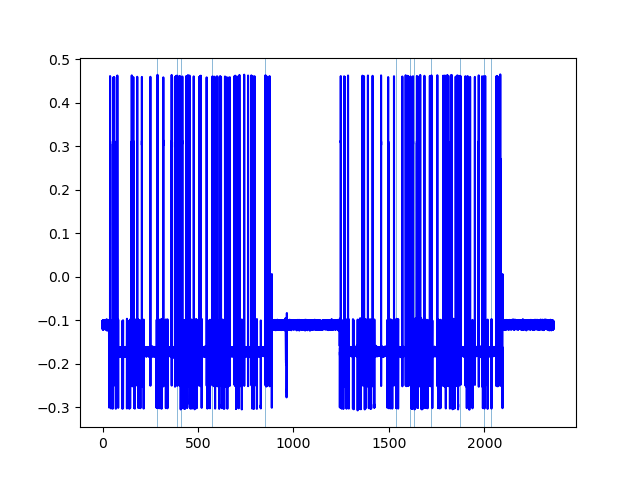

In [27]:
fig, ax = plt.subplots()
ax.plot(synctime, photodiode, 'b')

for ind, row in vis_stim.iterrows():
    ax.axvspan(row.onset, row.offset, alpha=0.5)

<IPython.core.display.Javascript object>


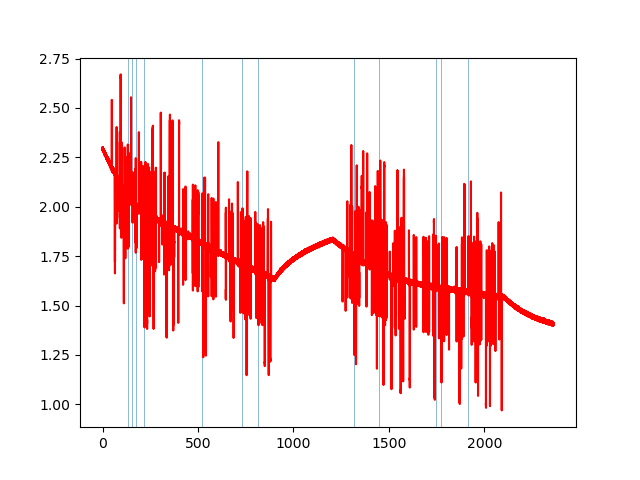

In [28]:
fig, ax = plt.subplots()
ax.plot(synctime, speaker_input, 'r')

for ind, row in aud_stim.iterrows():
    ax.axvspan(row.onset, row.offset, alpha=0.5)

Loop through all stim and look through photodiode or speaker signal to find real onset/offset times.

In [37]:
search_window = 0.1 # s, before and after
search_sample = int(search_window * samp_rate)
# try
z_thresh = 5

onset_delays = np.zeros(len(vsync_log)) # initialize array to hold delays
offset_delays = np.zeros(len(vsync_log)) # initialize array to hold delays
for ind, row in vsync_log.iterrows():
    onset_ind = int(row.onset * samp_rate)
    offset_ind = int(row.offset * samp_rate)
    
    if row.stim_type == 'fullscreen':
        onset_chunk = photodiode[onset_ind - search_sample:onset_ind + search_sample]
        offset_chunk = photodiode[offset_ind - search_sample:offset_ind + search_sample]
    elif row.stim_type == 'auditory':
        onset_chunk = speaker_input[onset_ind - search_sample:onset_ind + search_sample]
        offset_chunk = speaker_input[offset_ind - search_sample:offset_ind + search_sample]
    
    # TIME stamps for chunks
    onset_t = synctime[onset_ind - search_sample:onset_ind + search_sample] - row.onset
    offset_t = synctime[offset_ind - search_sample:offset_ind + search_sample] - row.offset
    
    # ONSET DELAY
    onset_z = np.abs((onset_chunk - np.mean(onset_chunk[0:search_sample]))/np.std(onset_chunk[0:search_sample]))
    onset_z_thresh = z_thresh # (np.max(onset_z) - np.min(onset_z))*0.5
    onset_delays[ind] = onset_t[np.argwhere(onset_z > onset_z_thresh)[0]]
    
    # OFFSET DELAY
    if row.stim_type == 'fullscreen':
        offset_z = np.abs((offset_chunk - np.mean(offset_chunk[0:search_sample]))/np.std(offset_chunk[0:search_sample]))
        offset_z_thresh = z_thresh # (np.max(offset_z) - np.min(offset_z))*0.5
        offset_delays[ind] = offset_t[np.argwhere(offset_z > offset_z_thresh)[0]]
    elif row.stim_type == 'auditory':
        offset_z = np.abs((offset_chunk - np.mean(offset_chunk[0:search_sample]))/np.std(offset_chunk[0:search_sample]))
        offset_z_thresh = z_thresh # (np.max(offset_z) - np.min(offset_z))*0.5
        if len(np.argwhere(offset_z > offset_z_thresh))==0:
            offset_delays[ind] = np.nan
        else:
            offset_delays[ind] = offset_t[np.argwhere(offset_z > offset_z_thresh)[0]]

In [38]:
vsync_log['onset_delay'] = onset_delays
vsync_log['offset_delay'] = offset_delays

In [39]:
vsync_log

,stim_type,stim_parameter,onset,offset,onset_delay,offset_delay,duration
0,fullscreen,black,352.69426,352.96129,0.03074,0.03161,0.26790
1,auditory,whitenoise,357.77752,358.04313,0.01648,NaN,0.24913
2,auditory,whitenoise,362.70107,362.96330,0.01293,NaN,0.24930
3,fullscreen,white,367.70749,367.97437,0.02881,0.02883,0.26690
4,auditory,whitenoise,372.69197,372.95339,0.01223,NaN,0.24919
...,...,...,...,...,...,...,...
475,fullscreen,white,3137.10318,3137.37003,0.02872,0.02877,0.26690
476,fullscreen,black,3142.10702,3142.37387,0.02888,0.02983,0.26780
477,auditory,10000,3147.09565,3147.35645,0.01235,-0.00155,0.24845
478,auditory,10000,3152.08266,3152.34628,0.01564,-0.00138,0.24798


In [40]:
vsync_log.groupby(['stim_type']).mean()

,onset,offset,onset_delay,offset_delay,duration
stim_type,,,,,
auditory,1723.982477,1724.247652,0.015250,-0.001122,0.249925
fullscreen,1785.820258,1786.087051,0.028515,0.028133,0.266411


In [41]:
vsync_log.groupby(['stim_type']).std()

,onset,offset,onset_delay,offset_delay,duration
stim_type,,,,,
auditory,873.794278,873.793958,0.010353,0.001900,0.009992
fullscreen,880.940132,880.940148,0.005286,0.011372,0.012620


In [42]:
vis_stim = vsync_log[vsync_log['stim_type'] == 'fullscreen']
aud_stim = vsync_log[vsync_log['stim_type'] == 'auditory']

In [43]:
fig, ax = plt.subplots()
ax.plot(synctime, photodiode, 'b')

for ind, row in vis_stim.iterrows():
    ax.axvspan(row.onset+row.onset_delay, row.offset+row.offset_delay, alpha=0.5)
    if (row.offset_delay < (0.027-0.014)) or (row.offset_delay > (0.027+0.014)):
        ax.plot(row.offset, 0.3, 'ro')

<IPython.core.display.Javascript object>

#### Add sweep column to log

In [44]:
vsync_log['sweep'] = np.zeros(len(vsync_log), dtype=int) - 1
vsync_log.head()

,stim_type,stim_parameter,onset,offset,onset_delay,offset_delay,duration,sweep
0,fullscreen,black,352.69426,352.96129,0.03074,0.03161,0.26790,-1
1,auditory,whitenoise,357.77752,358.04313,0.01648,NaN,0.24913,-1
2,auditory,whitenoise,362.70107,362.96330,0.01293,NaN,0.24930,-1
3,fullscreen,white,367.70749,367.97437,0.02881,0.02883,0.26690,-1
4,auditory,whitenoise,372.69197,372.95339,0.01223,NaN,0.24919,-1


In [45]:
for i in range(len(srising)):
    sweep_start = srising[i]
    sweep_end = sfalling[i]
    print('Sweep %d: %f to %f' % (i, sweep_start, sweep_end))
    vsync_log.loc[(vsync_log['onset'] > sweep_start) & (vsync_log['onset'] < sweep_end), 'sweep'] = i
vsync_log.head()

Sweep 0: 351.677780 to 1548.699680
Sweep 1: 1961.062460 to 3158.086850


,stim_type,stim_parameter,onset,offset,onset_delay,offset_delay,duration,sweep
0,fullscreen,black,352.69426,352.96129,0.03074,0.03161,0.26790,0
1,auditory,whitenoise,357.77752,358.04313,0.01648,NaN,0.24913,0
2,auditory,whitenoise,362.70107,362.96330,0.01293,NaN,0.24930,0
3,fullscreen,white,367.70749,367.97437,0.02881,0.02883,0.26690,0
4,auditory,whitenoise,372.69197,372.95339,0.01223,NaN,0.24919,0


In [46]:
vsync_log

,stim_type,stim_parameter,onset,offset,onset_delay,offset_delay,duration,sweep
0,fullscreen,black,352.69426,352.96129,0.03074,0.03161,0.26790,0
1,auditory,whitenoise,357.77752,358.04313,0.01648,NaN,0.24913,0
2,auditory,whitenoise,362.70107,362.96330,0.01293,NaN,0.24930,0
3,fullscreen,white,367.70749,367.97437,0.02881,0.02883,0.26690,0
4,auditory,whitenoise,372.69197,372.95339,0.01223,NaN,0.24919,0
...,...,...,...,...,...,...,...,...
475,fullscreen,white,3137.10318,3137.37003,0.02872,0.02877,0.26690,1
476,fullscreen,black,3142.10702,3142.37387,0.02888,0.02983,0.26780,1
477,auditory,10000,3147.09565,3147.35645,0.01235,-0.00155,0.24845,1
478,auditory,10000,3152.08266,3152.34628,0.01564,-0.00138,0.24798,1


### From previous analysis:

### How to threshold analog speaker signal?

What about a rolling z-score? Window should be longer than stimuli duration, 250 ms.

In [47]:
## AUDITORY SIGNAL ##
numind = 88
test_onset = aud_stim['onset'].loc[numind]

onset_sample = int(test_onset * samp_rate)
search_window = 0.1 # s, before and after
search_sample = int(search_window * samp_rate)

speaker_chunk = speaker_input[onset_sample - search_sample:onset_sample + search_sample]
BL = np.mean(speaker_chunk[0:search_sample])
STD = np.std(speaker_chunk[0:search_sample])
chunkz = np.abs((speaker_chunk-BL)/STD)
timex = synctime[onset_sample - search_sample:onset_sample + search_sample] - test_onset
z_thresh = 5
delay = timex[np.argwhere(chunkz > z_thresh)[0]]

# half_window = 10
# rolling_std = np.zeros(len(speaker_chunk))
# amp = np.zeros(len(speaker_chunk))
# for ii in range(len(rolling_std)):
#     center_sample = onset_sample + ii
#     rolling_std[ii] = np.std(speaker_input[center_sample - half_window:center_sample + half_window])
#     amp[ii] = np.max(speaker_input[center_sample - half_window:center_sample + half_window]) - np.min(speaker_input[center_sample - half_window:center_sample + half_window])

fig, ax = plt.subplots()
ax.plot(timex, speaker_chunk, 'b', alpha=0.6, label='speaker signal')
ax1 = ax.twinx()
ax1.plot(timex, chunkz, 'm', alpha=0.75)
# ax1.set_ylim([0, 0.02])
ax.axvline(x=0, c='black', label='vsync onset')
ax.axvline(x=delay, c='red', label='est. delay')
ax1.axhline(y=STD, c='green', label='baseline std')
ax1.axhline(y=5, c='teal', label='threshold')
ax.set_title('Auditory stim #%d\nEstimated delay = %0.4f ms' % (numind, delay))
ax.set_xlabel('Time from vsync pulse onset (s)')
ax.set_ylabel('Speaker signal (V)')
ax.legend()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


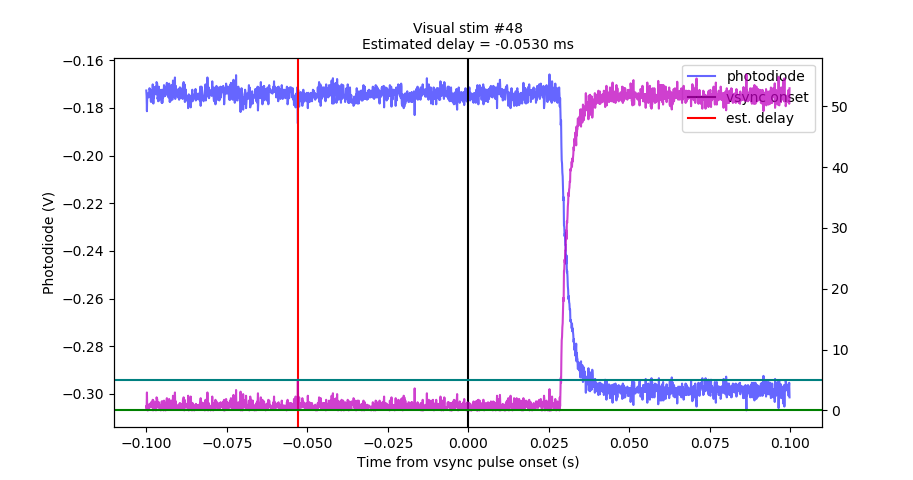

In [51]:
## PHOTODIODE SIGNAL ##
numind = 48
test_onset = vis_stim['onset'].loc[numind]

onset_sample = int(test_onset * samp_rate)
search_window = 0.1 # s, before and after
search_sample = int(search_window * samp_rate)

sig_chunk = photodiode[onset_sample - search_sample:onset_sample + search_sample]
BL = np.mean(sig_chunk[0:search_sample])
STD = np.std(sig_chunk[0:search_sample])
chunkz = np.abs((sig_chunk-BL)/STD)
timex = synctime[onset_sample - search_sample:onset_sample + search_sample] - test_onset
z_thresh = 5
delay = timex[np.argwhere(chunkz > z_thresh)[0]]

fig, ax = plt.subplots()
ax.plot(timex, sig_chunk, 'b', alpha=0.6, label='photodiode')
ax1 = ax.twinx()
ax1.plot(timex, chunkz, 'm', alpha=0.75)
# ax1.set_ylim([0, 0.02])
ax.axvline(x=0, c='black', label='vsync onset')
ax.axvline(x=delay, c='red', label='est. delay')
ax1.axhline(y=STD, c='green', label='baseline std')
ax1.axhline(y=5, c='teal', label='threshold')
ax.set_title('Visual stim #%d\nEstimated delay = %0.4f ms' % (numind, delay))
ax.set_xlabel('Time from vsync pulse onset (s)')
ax.set_ylabel('Photodiode (V)')
ax.legend()

In [49]:
# aud_delays[32] = 0.023
# aud_delays[144] = 0.015

In [50]:
print('Mean auditory delay = %0.3f ms' % (np.mean(aud_delays)*1000))
print('Auditory delay standard deviation = %0.5f ms' % (np.std(aud_delays)*1000))
print('Auditory delay max = %0.3f ms' % (np.max(aud_delays)*1000))
print('Auditory delay min = %0.3f ms' % (np.min(aud_delays)*1000))

NameError: name 'aud_delays' is not defined

### Testing Irene's visual_stim_lag function

In [ ]:
vislagmean, vislagstd = visual_stim_lag(photodiode, log_file, vfalling, flag_plot=1)

In [ ]:
print(vislagmean)
print(vislagstd)